# Análisis de Clustering y Paralelización

## Preprocesamiento y clustering secuencial

C:\Users\122578\AppData\Local\Temp\ipykernel_7768\1798555240.py:302: DtypeWarning: Columns (2,4,6,48,54,56,59,85,91,93,95,97,99,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('03_CAP200AB.csv',sep=",")
C:\Users\122578\AppData\Local\Temp\ipykernel_7768\1798555240.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado[num_cols_validas] = imputer_num.fit_transform(df_filtrado[num_cols_validas])
C:\Users\122578\AppData\Local\Temp\ipykernel_7768\1798555240.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

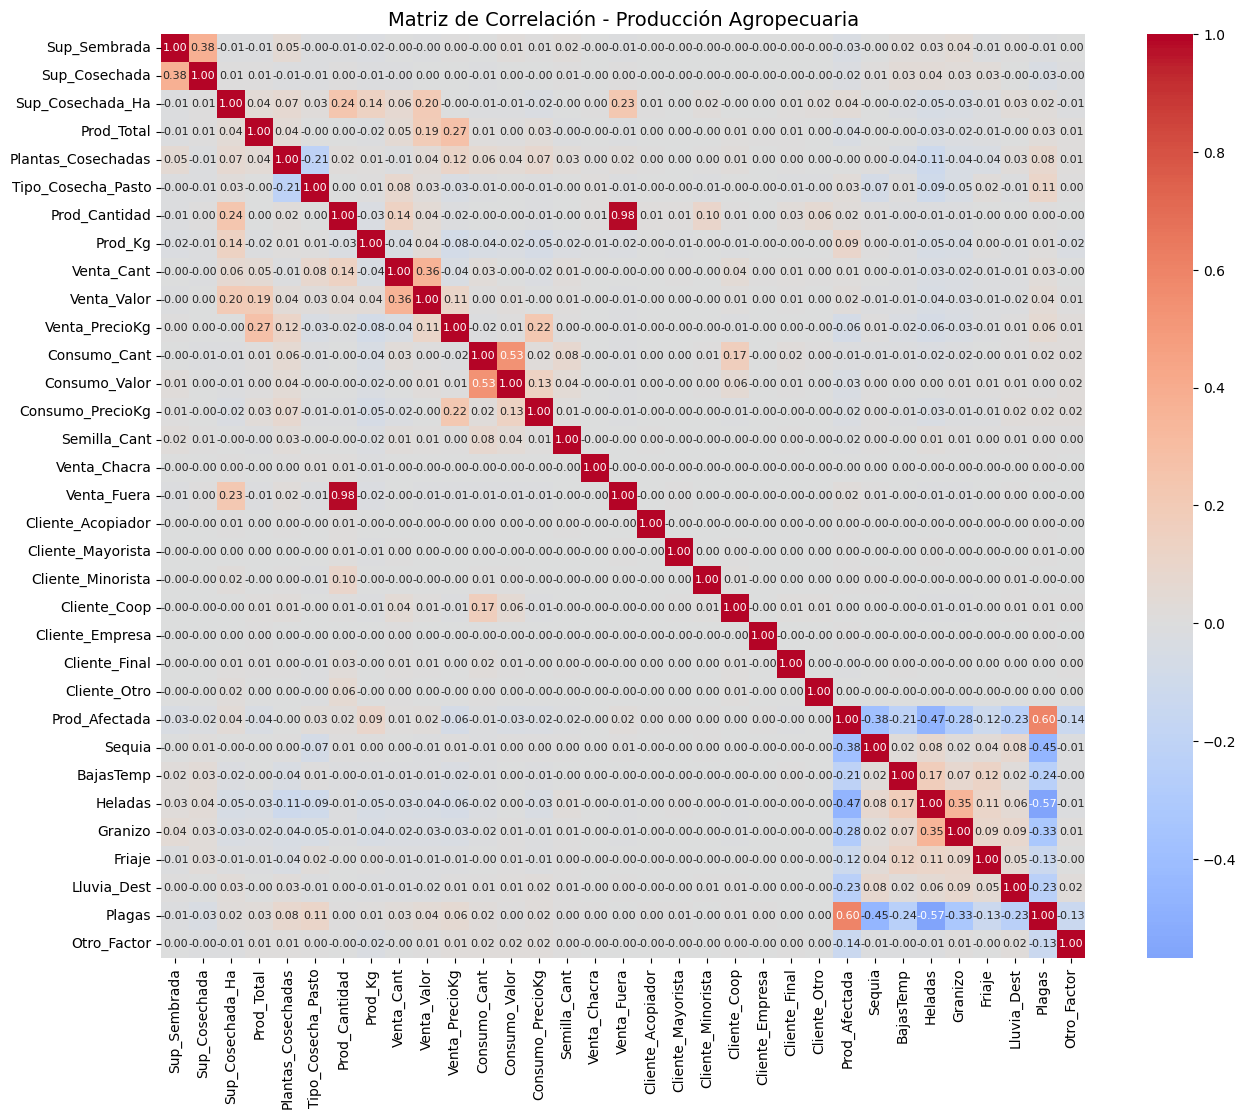


=== PCA ===
Varianza explicada por cada componente:
[0.19348514 0.17839575]

Cargas de las variables en los componentes:
                    PC1       PC2
Sup_Sembrada   0.023204 -0.118126
Sup_Cosechada  0.009758 -0.104750
Prod_Total     0.074482  0.367154
Venta_Cant     0.140077  0.596412
Venta_Valor    0.143106  0.664258
Consumo_Cant   0.685950 -0.139205
Consumo_Valor  0.678431 -0.154094
Semilla_Cant   0.151400 -0.014246

PC1 está más relacionado con:
Consumo_Cant     0.685950
Consumo_Valor    0.678431
Semilla_Cant     0.151400
Venta_Valor      0.143106
Venta_Cant       0.140077
Name: PC1, dtype: float64

PC2 está más relacionado con:
Venta_Valor      0.664258
Venta_Cant       0.596412
Prod_Total       0.367154
Consumo_Valor   -0.154094
Consumo_Cant    -0.139205
Name: PC2, dtype: float64


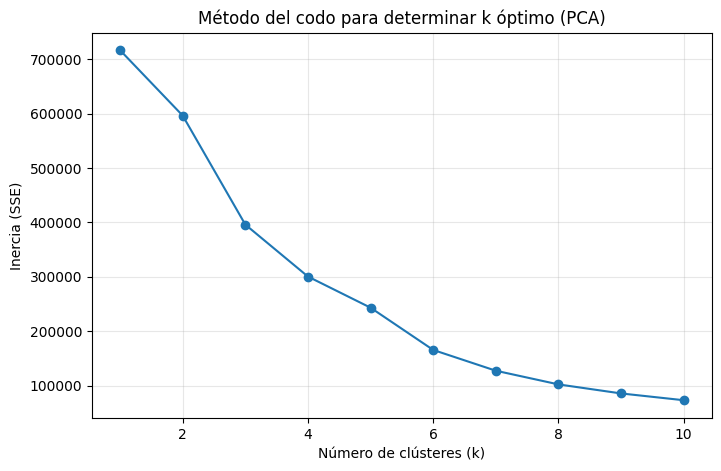


=== Interpretación de clusters ===

Cluster 0:
Variables más diferenciadoras (respecto a la media):
Venta_Valor     -1154.387339
Venta_Cant       -529.921491
Sup_Cosechada     -53.957022
Prod_Total        -53.082206
Sup_Sembrada      -34.998254
Name: 0, dtype: float64

Cluster 1:
Variables más diferenciadoras (respecto a la media):
Sup_Cosechada    6755.823234
Sup_Sembrada     4414.933815
Venta_Valor     -1377.208140
Venta_Cant       -665.480586
Consumo_Valor     112.152102
Name: 1, dtype: float64

Cluster 2:
Variables más diferenciadoras (respecto a la media):
Venta_Valor      184202.287635
Venta_Cant        94694.295112
Prod_Total          502.660463
Sup_Cosechada      -128.451872
Sup_Sembrada        -55.508288
Name: 2, dtype: float64

Cluster 3:
Variables más diferenciadoras (respecto a la media):
Consumo_Valor    8705.129289
Venta_Cant       2928.480045
Venta_Valor      2213.956763
Consumo_Cant     2205.717806
Prod_Total        233.073959
Name: 3, dtype: float64

Cluster 4:
Variab

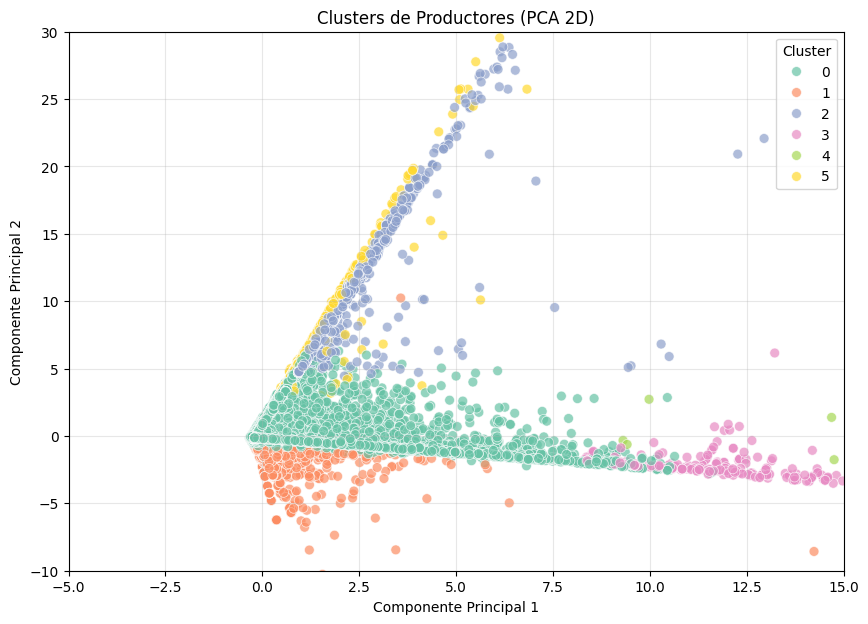


Tiempo total de ejecución: 182.51 segundos
Memoria máxima usada: 1209.95 MB


In [ ]:
import pandas as pd
import os
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time
import tracemalloc

#Funciones para el proceso
def juntar_df(df1,df2):
    x = []
    for col1 in df1.columns:
       for col2 in df2.columns:
          if col1 == col2:
            x.append(col2)
    df_final = pd.merge(df1,df2,on=x,how='outer')
    return df_final


def juntar_entero_con_decimal(df, col1_name, col2_name, nom):
    df[col1_name] = df[col1_name].replace(' ', 0).fillna(0)
    df[col2_name] = df[col2_name].replace(' ', 0).fillna(0)

    df[nom] = df[col1_name].astype(int).astype(str) + '.' + df[col2_name].astype(int).astype(str)
    df[nom] = df[nom].astype(float)

    df.drop(columns=[col1_name, col2_name], inplace=True)

def limpieza_df(df_final):
   df_final.drop_duplicates(inplace=True)
   df_final = df_final.reset_index(drop=True)

   masc_filas = df_final.isna().sum(axis=1) / df_final.shape[1]
   # eliminar las filas con más del 70% de NaN
   thresh = int(0.3 * df_final.shape[1]) + 1
   df_final = df_final.dropna(axis=0, thresh=thresh)
   ((df_final.isna().sum(axis=1) / df_final.shape[1]) > 0.7).any()

def filtrar_columnas(df_final):
   columnas_utiles_cod = [
    # Identificación mínima
    "CCDD", "NOMBREDD", "CCPP", "NOMBREPV", "CCDI", "NOMBREDI", "REGION",
    "ID_PROD", "ESTRATO", "FACTOR_PRODUCTOR",
    # Superficie
    "P210_SUP", "P217_SUP", "P217_SUP_ha",
    # Producción
    "P218", "P218A", "P218B", "P219_CANT", "P219_UM", "P219_UM_COD", "P219_EQUIV_KG",
    # Destino: venta
    "P220_1_CANT", "P220_1_VAL", "P220_1_PRE_KG",
    # Destino: consumo
    "P220_2", "P220_2_VAL", "P220_2_PRE_KG",
    # Destino: semilla
    "P220_3", "P220_3A", "P220_3A_VAL", "P220_3A_PRE_KG",
    "P220_3B", "P220_3B_VAL", "P220_3B_PRE_KG",
    # Otros destinos
    "P220_4", "P220_5", "P220_6", "P220_7", "P220_8",
    "P220_9", "P220_10", "P220_11", "P220_12",
    # Comercialización
    "P221_1", "P221_2",
    "P222_1", "P222_2", "P222_3", "P222_4", "P222_5", "P222_6", "P222_7",
    "P223_1", "P223_2", "P223_3", "P223_4", "P223_5", "P223_6",
    # Factores de riesgo
    "P223A", "P223B_1", "P223B_2", "P223B_3", "P223B_4",
    "P223B_5", "P223B_6", "P223B_7", "P223B_8"
    ]
   df_filtrado = df_final[columnas_utiles_cod]
   return df_filtrado

def limpieza2(df_filtrado):
   num_cols = [
    "P210_SUP", "P217_SUP", "P217_SUP_ha",        # superficies
    "P218", "P218A", "P218B", "P219_CANT", "P219_EQUIV_KG",  # producción
    "P220_1_CANT", "P220_1_VAL", "P220_1_PRE_KG",            # venta
    "P220_2", "P220_2_VAL", "P220_2_PRE_KG",                # consumo
    "P220_3", "P220_3A", "P220_3A_VAL", "P220_3A_PRE_KG",   # semilla auto
    "P220_3B", "P220_3B_VAL", "P220_3B_PRE_KG",             # semilla venta
    "P220_4", "P220_5", "P220_6", "P220_7", "P220_8",       # otros destinos
    "P220_9", "P220_10", "P220_11", "P220_12",
    "P223A"  # producción afectada
    ]
   cat_cols = [
    "CCDD", "NOMBREDD", "CCPP", "NOMBREPV", "CCDI", "NOMBREDI", "REGION",
    "ID_PROD", "ESTRATO", "FACTOR_PRODUCTOR",
    "P219_UM", "P219_UM_COD",
    "P221_1", "P221_2",
    "P222_1", "P222_2", "P222_3", "P222_4", "P222_5", "P222_6", "P222_7",
    "P223_1", "P223_2", "P223_3", "P223_4", "P223_5", "P223_6",
    "P223B_1", "P223B_2", "P223B_3", "P223B_4",
    "P223B_5", "P223B_6", "P223B_7", "P223B_8"
    ]
   #Eliminar filas con NaN en identificadores clave
   cols_principales = ["CCDD","NOMBREDD","CCPP","NOMBREPV","CCDI","NOMBREDI","REGION","ID_PROD","ESTRATO","FACTOR_PRODUCTOR"]
   df_filtrado = df_filtrado.dropna(subset=cols_principales)
   
   #Detectar columnas numéricas realmente válidas (no todas NaN)
   num_cols_validas = [col for col in num_cols if df_filtrado[col].notna().any()]
   
   #Imputar numéricas (con mediana)
   imputer_num = SimpleImputer(strategy="median")
   df_filtrado[num_cols_validas] = imputer_num.fit_transform(df_filtrado[num_cols_validas])
   
   #Imputar categóricas (con moda)
   imputer_cat = SimpleImputer(strategy="most_frequent")
   df_filtrado[cat_cols] = imputer_cat.fit_transform(df_filtrado[cat_cols])
   
   #Imputar factores de riesgo (NaN = no afectado)
   riesgo_cols = ["P223B_1","P223B_2","P223B_3","P223B_4","P223B_5","P223B_6","P223B_7","P223B_8"]
   df_filtrado[riesgo_cols] = df_filtrado[riesgo_cols].fillna(0)

   nulos = dict(df_filtrado.isna().sum())
   # Columnas totalmente vacías
   cols_vacias = [col for col, n in nulos.items() if n > 0 and n == max(nulos.values())]
   # Eliminar del dataframe
   df_filtrado = df_filtrado.drop(columns=cols_vacias)

   return df_filtrado

def renombrar_variables(df_filtrado):
   rename_dict = {
    # Identificación / Ubicación
    "CCDD": "Cod_Dep",
    "NOMBREDD": "Departamento",
    "CCPP": "Cod_Prov",
    "NOMBREPV": "Provincia",
    "CCDI": "Cod_Dist",
    "NOMBREDI": "Distrito",
    "REGION": "Region",
    "ID_PROD": "Id_Productor",
    "ESTRATO": "Estrato",
    "FACTOR_PRODUCTOR": "Factor_Expansion",
    # Superficie
    "P210_SUP": "Sup_Sembrada",
    "P217_SUP": "Sup_Cosechada",
    "P217_SUP_ha": "Sup_Cosechada_Ha",
    # Producción
    "P218": "Prod_Total",
    "P218A": "Plantas_Cosechadas",
    "P218B": "Tipo_Cosecha_Pasto",
    "P219_CANT": "Prod_Cantidad",
    "P219_UM": "Prod_UM",
    "P219_UM_COD": "Prod_UM_Cod",
    "P219_EQUIV_KG": "Prod_Kg",
    # Destino: Venta
    "P220_1_CANT": "Venta_Cant",
    "P220_1_VAL": "Venta_Valor",
    "P220_1_PRE_KG": "Venta_PrecioKg",
    # Destino: Consumo
    "P220_2": "Consumo_Cant",
    "P220_2_VAL": "Consumo_Valor",
    "P220_2_PRE_KG": "Consumo_PrecioKg",
    # Destino: Semilla
    "P220_3": "Semilla_Cant",
    "P220_3A": "Semilla_Autoconsumo",
    "P220_3B": "Semilla_Venta",
    # Otros destinos
    "P220_4": "Venta_Chacra",
    "P220_5": "Venta_Fuera",
    "P220_6": "Cliente_Acopiador",
    "P220_7": "Cliente_Mayorista",
    "P220_8": "Cliente_Minorista",
    "P220_9": "Cliente_Coop",
    "P220_10": "Cliente_Empresa",
    "P220_11": "Cliente_Final",
    "P220_12": "Cliente_Otro",
    # Mercados
    "P221_1": "Merc_Local",
    "P221_2": "Merc_Regional",
    # Factores de destino adicional
    "P222_1": "Merc_Exterior",
    "P222_2": "Merc_Agroind",
    "P222_3": "Merc_Lima",
    "P222_4": "Merc_NoSabe",
    "P222_5": "Otro_Merc1",
    "P222_6": "Otro_Merc2",
    "P222_7": "Otro_Merc3",
    # Factores de pérdida / riesgo
    "P223_1": "Perdida_PreCosecha",
    "P223_2": "Perdida_Cosecha",
    "P223_3": "Robo",
    "P223_4": "Donacion",
    "P223_5": "Trueque",
    "P223_6": "Pago_Especies",
    "P223A": "Prod_Afectada",
    # Factores de riesgo detallados
    "P223B_1": "Sequia",
    "P223B_2": "BajasTemp",
    "P223B_3": "Heladas",
    "P223B_4": "Granizo",
    "P223B_5": "Friaje",
    "P223B_6": "Lluvia_Dest",
    "P223B_7": "Plagas",
    "P223B_8": "Otro_Factor",
    }
   df_filtrado = df_filtrado.rename(columns=rename_dict)
   return df_filtrado

def analisis_correlacion(df_filtrado):
    # Columnas que NO deben entrar a correlación (identificación/categóricas)
    cols_excluir = ["Cod_Dep", "Departamento", "Cod_Prov", "Provincia",
                    "Cod_Dist", "Distrito", "Region", "Id_Productor",
                    "Estrato", "Factor_Expansion", "Prod_UM", "Prod_UM_Cod", 
                    'Semilla_Autoconsumo', 'Semilla_Venta']
    # Variables numéricas útiles
    num_cols = [col for col in df_filtrado.columns if col not in cols_excluir and pd.api.types.is_numeric_dtype(df_filtrado[col])]
    # Matriz de correlación
    corr = df_filtrado[num_cols].corr()
    return corr

#Grafica metodo del codo
def plot_elbow(X_pca, max_k=10):
    inertia = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_pca)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, marker='o')
    plt.xlabel("Número de clústeres (k)")
    plt.ylabel("Inercia (SSE)")
    plt.title("Método del codo para determinar k óptimo (PCA)")
    plt.grid(True, alpha=0.3)
    plt.show()

def analisis_cluster(df):
   cols_cluster = ["Sup_Sembrada", "Sup_Cosechada", "Prod_Total",
                    "Venta_Cant", "Venta_Valor", 
                    "Consumo_Cant", "Consumo_Valor", "Semilla_Cant"]
   cols_existentes = [col for col in cols_cluster if col in df.columns]
   if len(cols_existentes) < 2 or len(df) < 100:
      # Siempre devolvemos un array 2D para no romper el flujo
      return np.array([[0, 0]])
        
   # Preparar datos
   X = df[cols_existentes].fillna(0).values
   # Escalado
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
        
   # PCA
   pca = PCA(n_components=2)
   X_pca = pca.fit_transform(X_scaled)
        
   #Análisis de componentes principales ----
   explained_variance = pca.explained_variance_ratio_
   loadings = pd.DataFrame(
       pca.components_.T, 
       columns=[f"PC{i+1}" for i in range(len(pca.components_))],
       index=cols_existentes)
        
   print("\n=== PCA ===")
   print("Varianza explicada por cada componente:")
   print(explained_variance)
   print("\nCargas de las variables en los componentes:")
   print(loadings)
        
   for i in range(len(pca.components_)):
      comp = loadings.iloc[:, i].sort_values(key=abs, ascending=False)
      print(f"\nPC{i+1} está más relacionado con:")
      print(comp.head(5))
            
   # Clustering
   kmeans = KMeans(n_clusters=5, n_init=5, max_iter=100, random_state=42, algorithm='elkan')
   df["Cluster"] = kmeans.fit_predict(X_scaled)
        
   return X_pca


def interpretar_clusters(df, cols_cluster, cluster_col="Cluster"):
    # Asegurar que solo se usen las columnas numéricas de interés
    cols_existentes = [col for col in cols_cluster if col in df.columns]

    # Promedio general
    media_general = df[cols_existentes].mean()

    # Promedio por cluster
    resumen_clusters = df.groupby(cluster_col)[cols_existentes].mean()

    # Diferencia relativa respecto a la media general
    diferencias = resumen_clusters - media_general

    print("\n=== Interpretación de clusters ===")
    for c in resumen_clusters.index:
        print(f"\nCluster {c}:")
        desc = diferencias.loc[c].sort_values(key=abs, ascending=False)
        print("Variables más diferenciadoras (respecto a la media):")
        print(desc.head(5))

    return resumen_clusters, diferencias


if __name__ == "__main__":
   # Iniciar medición de tiempo y memoria
   start_time = time.time()
   tracemalloc.start()
   #Carga datos
   df1 = pd.read_csv('03_CAP200AB.csv',sep=",")
   df2 = pd.read_csv('03_CAP200A.csv',sep=",")
   df_final = juntar_df(df1,df2)

   #Limpieza
   limpieza_df(df_final)
   juntar_entero_con_decimal(df_final, 'P210_SUP_1', 'P210_SUP_2', 'P210_SUP')
   juntar_entero_con_decimal(df_final, 'P217_SUP_1', 'P217_SUP_2', 'P217_SUP')
   juntar_entero_con_decimal(df_final, 'P219_CANT_1', 'P219_CANT_2', 'P219_CANT')
   juntar_entero_con_decimal(df_final, 'P220_1_CANT_1', 'P220_1_CANT_2', 'P220_1_CANT')
   juntar_entero_con_decimal(df_final, 'P220_1_PREC_1', 'P220_1_PREC_2', 'P220_1_PREC')
   juntar_entero_con_decimal(df_final, 'P220_2_ENT', 'P220_2_DEC', 'P220_2')
   juntar_entero_con_decimal(df_final, 'P220_2_PREC_1', 'P220_2_PREC_2', 'P220_2_PREC')
   juntar_entero_con_decimal(df_final, 'P220_3_ENT', 'P220_3_DEC', 'P220_3')
   juntar_entero_con_decimal(df_final, 'P220_3A_ENT', 'P220_3A_DEC', 'P220_3A')
   juntar_entero_con_decimal(df_final, 'P220_3A_PREC_1', 'P220_3A_PREC_2', 'P220_3A_PREC')
   juntar_entero_con_decimal(df_final, 'P220_3B_ENT', 'P220_3B_DEC', 'P220_3B')
   juntar_entero_con_decimal(df_final, 'P220_3B_PREC_1', 'P220_3B_PREC_2', 'P220_3B_PREC')
   juntar_entero_con_decimal(df_final, 'P220_4_ENT', 'P220_4_DEC', 'P220_4')
   juntar_entero_con_decimal(df_final, 'P220_5_ENT', 'P220_5_DEC', 'P220_5')
   juntar_entero_con_decimal(df_final, 'P220_6_ENT', 'P220_6_DEC', 'P220_6')
   juntar_entero_con_decimal(df_final, 'P220_7_ENT', 'P220_7_DEC', 'P220_7')
   juntar_entero_con_decimal(df_final, 'P220_8_ENT', 'P220_8_DEC', 'P220_8')
   juntar_entero_con_decimal(df_final, 'P220_9_ENT', 'P220_9_DEC', 'P220_9')
   juntar_entero_con_decimal(df_final, 'P220_10_ENT', 'P220_10_DEC', 'P220_10')
   juntar_entero_con_decimal(df_final, 'P220_11_ENT', 'P220_11_DEC', 'P220_11')
   juntar_entero_con_decimal(df_final, 'P220_12_ENT', 'P220_12_DEC', 'P220_12')
   df_filtrado = filtrar_columnas(df_final)
   df_filtrado = limpieza2(df_filtrado)
   df_filtrado = renombrar_variables(df_filtrado)

   #Correlaccion
   corr = analisis_correlacion(df_filtrado)
   plt.figure(figsize=(16,12))
   sns.heatmap(corr,annot=True,fmt=".2f",cmap="coolwarm",center=0,cbar=True,square=True,linewidths=0,annot_kws={"size":8})
   plt.title("Matriz de Correlación - Producción Agropecuaria", fontsize=14)
   plt.xticks(rotation=90)
   plt.yticks(rotation=0)
   plt.show()

   #PCA
   cols_cluster = ["Sup_Sembrada", "Sup_Cosechada", "Prod_Total","Venta_Cant", "Venta_Valor", "Consumo_Cant", "Consumo_Valor", "Semilla_Cant"]
   X_pca = analisis_cluster(df_filtrado)

   # Gráfico del codo para k óptimo
   plot_elbow(X_pca, max_k=10)

   #Cluster
   interpretar_clusters(df_filtrado, cols_cluster, cluster_col="Cluster")
   plt.figure(figsize=(10,7))
   plt.xlim(-5, 15)
   plt.ylim(-10, 30)
   sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_filtrado["Cluster"], palette="Set2", s=50, alpha=0.7)
   plt.title("Clusters de Productores (PCA 2D)")
   plt.xlabel("Componente Principal 1")
   plt.ylabel("Componente Principal 2")
   plt.legend(title="Cluster")
   plt.grid(True, alpha=0.3)
   plt.show()

   # Fin de medición
   end_time = time.time()
   current, peak = tracemalloc.get_traced_memory()
   tracemalloc.stop()

   tiempo_total_secuencial = end_time - start_time

   print(f"\n{'='*50}")
   print(f"Tiempo total de ejecución: {tiempo_total_secuencial:.2f} segundos")
   print(f"Memoria máxima usada: {peak / 1024**2:.2f} MB")
   print(f"{'='*50}")


## Preprocesamiento y clustering paralelo

=== PIPELINE PARALELIZADO COMPLETO ===
Usando 16 núcleos de CPU

=== PCA ===
Varianza explicada por cada componente:
[0.19347156 0.17839996]

Cargas de las variables en los componentes:
                    PC1       PC2
Sup_Sembrada   0.024988 -0.116410
Sup_Cosechada  0.011145 -0.102995
Prod_Total     0.073735  0.367534
Venta_Cant     0.138817  0.596963
Venta_Valor    0.141729  0.664860
Consumo_Cant   0.686182 -0.137592
Consumo_Valor  0.678879 -0.152235
Semilla_Cant   0.150779 -0.015787

PC1 está más relacionado con:
Consumo_Cant     0.686182
Consumo_Valor    0.678879
Semilla_Cant     0.150779
Venta_Valor      0.141729
Venta_Cant       0.138817
Name: PC1, dtype: float64

PC2 está más relacionado con:
Venta_Valor      0.664860
Venta_Cant       0.596963
Prod_Total       0.367534
Consumo_Valor   -0.152235
Consumo_Cant    -0.137592
Name: PC2, dtype: float64

=== Interpretación de clusters ===

Cluster 0:
Variables más diferenciadoras (respecto a la media):
Sup_Cosechada    7646.356940
Sup_

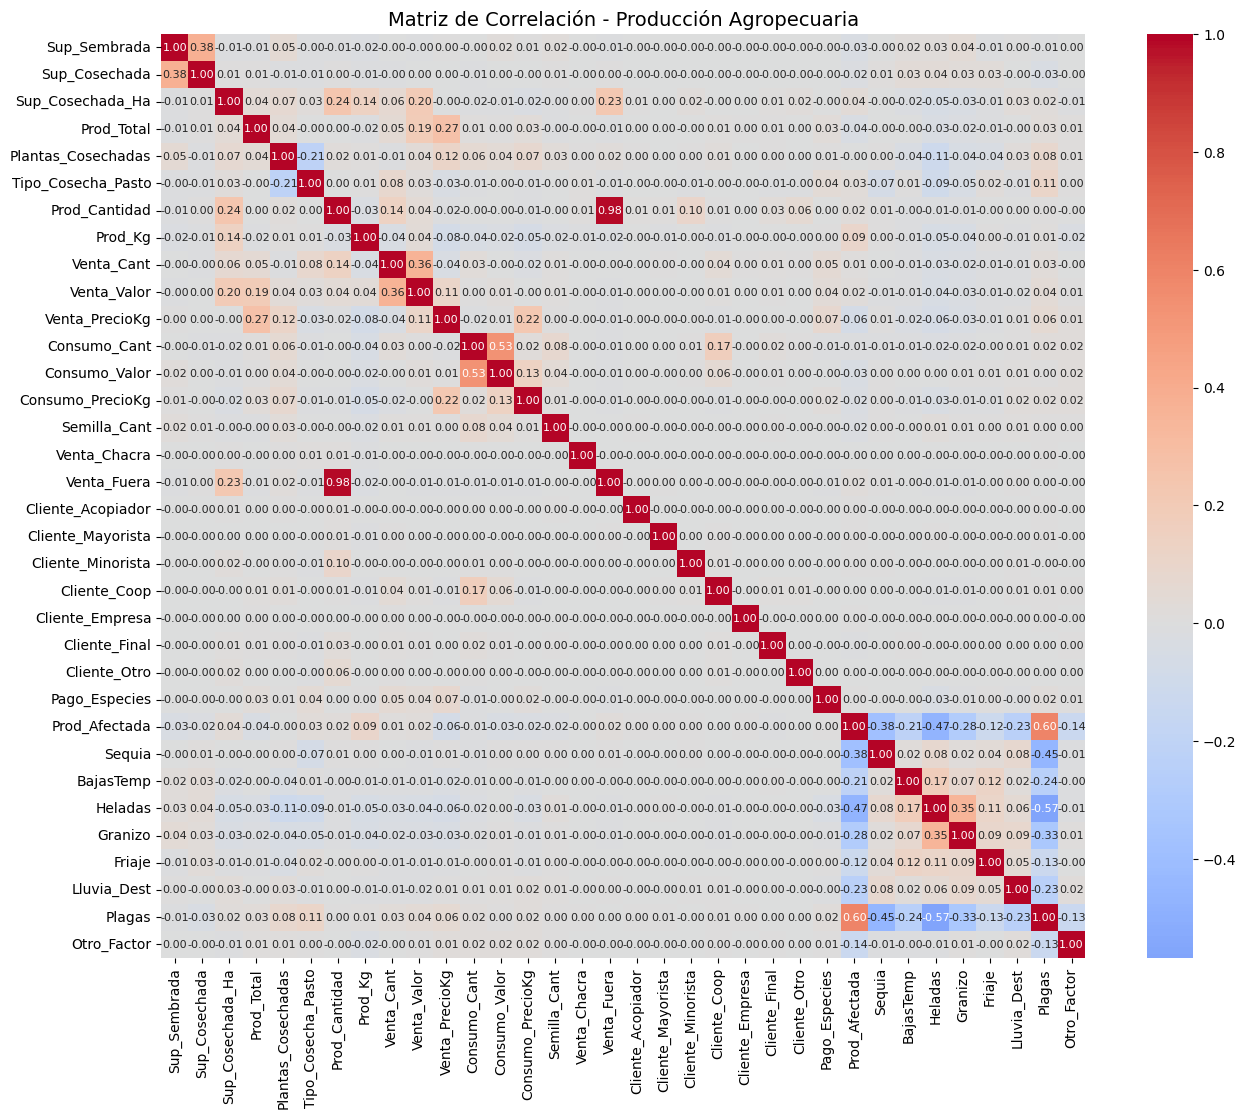

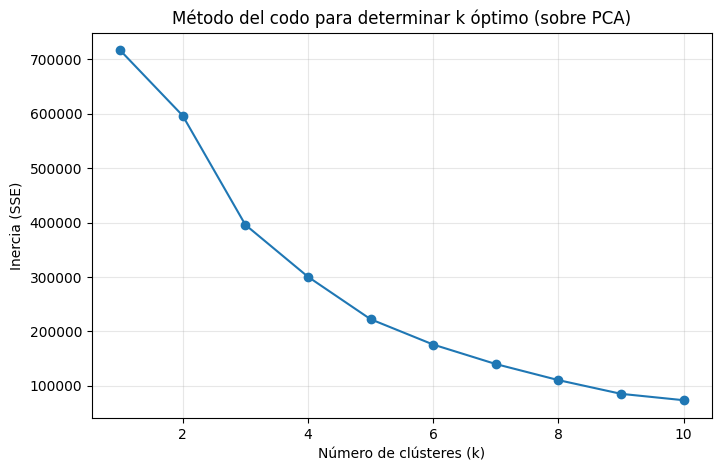

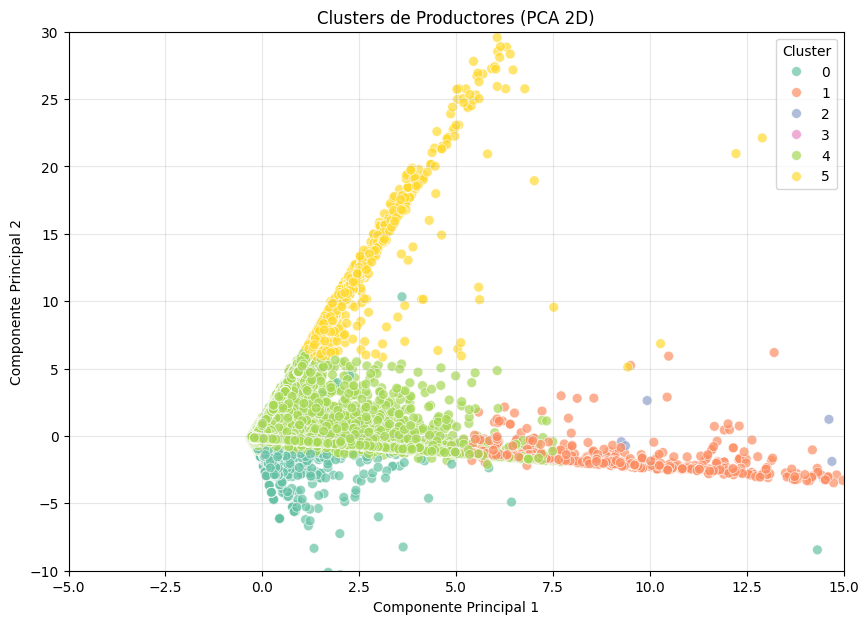

Total de gráficos generados: 3/3

TIEMPO TOTAL: 87.12 segundos
Memoria pico: 1072.0 MB
Aceleración estimada: 2.1x vs versión secuencial


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

#CPU a utiliar
NUM_CORES = cpu_count()
CHUNK_SIZE = 10000

#Funciones para el proceso de paralelizacion
def cargar_datos_paralelo():
    def cargar_csv(filename):
        return pd.read_csv(filename, sep=",", low_memory=False, engine='c')
    
    with ThreadPoolExecutor(max_workers=2) as executor:
        future_df1 = executor.submit(cargar_csv, '03_CAP200AB.csv')
        future_df2 = executor.submit(cargar_csv, '03_CAP200A.csv')
        df1 = future_df1.result()
        df2 = future_df2.result()

    return df1, df2

def juntar_df_optimizado(df1, df2):
    columnas_comunes = list(set(df1.columns) & set(df2.columns))
    return pd.merge(df1, df2, on=columnas_comunes, how='outer', copy=False, sort=False)


def juntar_entero_con_decimal_optimizado(df, columnas_pares):
    for i, (col1_name, col2_name, nom) in enumerate(columnas_pares):
        if col1_name not in df.columns or col2_name not in df.columns:
            df[nom] = 0.0
            continue
        try:
            col1_series = df[col1_name].replace([' ', '', np.nan], 0)
            col2_series = df[col2_name].replace([' ', '', np.nan], 0)
            col1_num = pd.to_numeric(col1_series, errors='coerce').fillna(0)
            col2_num = pd.to_numeric(col2_series, errors='coerce').fillna(0)
            df[nom] = col1_num + (col2_num / 100.0)
        except Exception as e:
            print(f"Error en columna {nom}: {e}")
            df[nom] = 0.0
    return df

def limpieza_df_ultrarapida(df_final):
    df_final = df_final.drop_duplicates(keep='first', ignore_index=True)
    thresh = int(0.3 * df_final.shape[1])
    df_final = df_final.dropna(axis=0, thresh=thresh)
    df_final.reset_index(drop=True, inplace=True)
    return df_final

def filtrar_y_limpiar_chunk_mejorado(args):
    chunk, columnas_utiles, cols_principales, medianas_globales, modas_globales, riesgo_cols = args
    cols_existentes = [col for col in columnas_utiles if col in chunk.columns]
    chunk_filtrado = chunk[cols_existentes].copy()

    if cols_principales:
        cols_principales_existentes = [col for col in cols_principales if col in chunk_filtrado.columns]
        chunk_filtrado = chunk_filtrado.dropna(subset=cols_principales_existentes)

    for col in chunk_filtrado.columns:
        if chunk_filtrado[col].isna().any():
            if col in medianas_globales:
                chunk_filtrado[col].fillna(medianas_globales[col], inplace=True)
            elif col in modas_globales:
                chunk_filtrado[col].fillna(modas_globales[col], inplace=True)

    riesgo_cols_existentes = [col for col in riesgo_cols if col in chunk_filtrado.columns]

    if riesgo_cols_existentes:
        chunk_filtrado[riesgo_cols_existentes] = chunk_filtrado[riesgo_cols_existentes].fillna(0)
    return chunk_filtrado

def pipeline_filtrado_limpieza_ultrarapido(df_final):
    columnas_utiles = [
        "CCDD", "NOMBREDD", "CCPP", "NOMBREPV", "CCDI", "NOMBREDI", "REGION",
        "ID_PROD", "ESTRATO", "FACTOR_PRODUCTOR",
        "P210_SUP", "P217_SUP", "P217_SUP_ha",
        "P218", "P218A", "P218B", "P219_CANT", "P219_UM", "P219_UM_COD", "P219_EQUIV_KG",
        "P220_1_CANT", "P220_1_VAL", "P220_1_PRE_KG",
        "P220_2", "P220_2_VAL", "P220_2_PRE_KG",
        "P220_3", "P220_3A", "P220_3A_VAL", "P220_3A_PRE_KG",
        "P220_3B", "P220_3B_VAL", "P220_3B_PRE_KG",
        "P220_4", "P220_5", "P220_6", "P220_7", "P220_8",
        "P220_9", "P220_10", "P220_11", "P220_12",
        "P221_1", "P221_2",
        "P222_1", "P222_2", "P222_3", "P222_4", "P222_5", "P222_6", "P222_7",
        "P223_1", "P223_2", "P223_3", "P223_4", "P223_5", "P223_6",
        "P223A", "P223B_1", "P223B_2", "P223B_3", "P223B_4",
        "P223B_5", "P223B_6", "P223B_7", "P223B_8"
    ]
    cols_principales = ["CCDD","NOMBREDD","CCPP","NOMBREPV","CCDI","NOMBREDI","REGION","ID_PROD","ESTRATO","FACTOR_PRODUCTOR"]
    riesgo_cols = ["P223B_1","P223B_2","P223B_3","P223B_4","P223B_5","P223B_6","P223B_7","P223B_8"]
    
    cols_existentes = [col for col in columnas_utiles if col in df_final.columns]
    df_filtrado = df_final[cols_existentes].copy()
    df_filtrado = df_filtrado.dropna(subset=cols_principales)

    num_cols = [
        "P210_SUP", "P217_SUP", "P217_SUP_ha",        # superficies
        "P218", "P218A", "P218B", "P219_CANT", "P219_EQUIV_KG",  # producción
        "P220_1_CANT", "P220_1_VAL", "P220_1_PRE_KG",            # venta
        "P220_2", "P220_2_VAL", "P220_2_PRE_KG",                # consumo
        "P220_3", "P220_3A", "P220_3A_VAL", "P220_3A_PRE_KG",   # semilla auto
        "P220_3B", "P220_3B_VAL", "P220_3B_PRE_KG",             # semilla venta
        "P220_4", "P220_5", "P220_6", "P220_7", "P220_8",       # otros destinos
        "P220_9", "P220_10", "P220_11", "P220_12",
        "P223A"  # producción afectada
        ]
    
    cat_cols = [
        "CCDD", "NOMBREDD", "CCPP", "NOMBREPV", "CCDI", "NOMBREDI", "REGION",
        "ID_PROD", "ESTRATO", "FACTOR_PRODUCTOR",
        "P219_UM", "P219_UM_COD",
        "P221_1", "P221_2",
        "P222_1", "P222_2", "P222_3", "P222_4", "P222_5", "P222_6", "P222_7",
        "P223_1", "P223_2", "P223_3", "P223_4", "P223_5", "P223_6",
        "P223B_1", "P223B_2", "P223B_3", "P223B_4",
        "P223B_5", "P223B_6", "P223B_7", "P223B_8"
        ]
    
    medianas_globales = {}
    modas_globales = {}

    num_cols_existentes = [col for col in num_cols if col in df_filtrado.columns]
    cat_cols_existentes = [col for col in cat_cols if col in df_filtrado.columns]

    for col in num_cols_existentes:
        medianas_globales[col] = df_filtrado[col].median()

    for col in cat_cols_existentes:
        mode_val = df_filtrado[col].mode()
        modas_globales[col] = mode_val.iloc[0] if len(mode_val) > 0 else 'Unknown'

    chunk_size = len(df_filtrado) // 4

    chunks = [df_filtrado.iloc[i:i+chunk_size].copy() 
              for i in range(0, len(df_filtrado), chunk_size)]
    
    tareas = [(chunk, columnas_utiles, cols_principales, medianas_globales, modas_globales, riesgo_cols) 
              for chunk in chunks]
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        chunks_procesados = list(executor.map(filtrar_y_limpiar_chunk_mejorado, tareas))
    df_resultado = pd.concat(chunks_procesados, ignore_index=True)
   
    nulos = dict(df_resultado.isna().sum())

    if nulos and max(nulos.values()) > 0:
        cols_vacias = [col for col, n in nulos.items() if n > 0 and n == max(nulos.values())]
        if cols_vacias:
            df_resultado = df_resultado.drop(columns=cols_vacias)

    return df_resultado

def renombrar_paralelo(df_filtrado):
    rename_dict = {
        # Identificación / Ubicación
        "CCDD": "Cod_Dep",
        "NOMBREDD": "Departamento",
        "CCPP": "Cod_Prov",
        "NOMBREPV": "Provincia",
        "CCDI": "Cod_Dist",
        "NOMBREDI": "Distrito",
        "REGION": "Region",
        "ID_PROD": "Id_Productor",
        "ESTRATO": "Estrato",
        "FACTOR_PRODUCTOR": "Factor_Expansion",
        # Superficie
        "P210_SUP": "Sup_Sembrada",
        "P217_SUP": "Sup_Cosechada",
        "P217_SUP_ha": "Sup_Cosechada_Ha",
        # Producción
        "P218": "Prod_Total",
        "P218A": "Plantas_Cosechadas",
        "P218B": "Tipo_Cosecha_Pasto",
        "P219_CANT": "Prod_Cantidad",
        "P219_UM": "Prod_UM",
        "P219_UM_COD": "Prod_UM_Cod",
        "P219_EQUIV_KG": "Prod_Kg",
        # Destino: Venta
        "P220_1_CANT": "Venta_Cant",
        "P220_1_VAL": "Venta_Valor",
        "P220_1_PRE_KG": "Venta_PrecioKg",
        # Destino: Consumo
        "P220_2": "Consumo_Cant",
        "P220_2_VAL": "Consumo_Valor",
        "P220_2_PRE_KG": "Consumo_PrecioKg",
        # Destino: Semilla
        "P220_3": "Semilla_Cant",
        "P220_3A": "Semilla_Autoconsumo",
        "P220_3B": "Semilla_Venta",
        # Otros destinos
        "P220_4": "Venta_Chacra",
        "P220_5": "Venta_Fuera",
        "P220_6": "Cliente_Acopiador",
        "P220_7": "Cliente_Mayorista",
        "P220_8": "Cliente_Minorista",
        "P220_9": "Cliente_Coop",
        "P220_10": "Cliente_Empresa",
        "P220_11": "Cliente_Final",
        "P220_12": "Cliente_Otro",
        # Mercados
        "P221_1": "Merc_Local",
        "P221_2": "Merc_Regional",
        # Factores de destino adicional
        "P222_1": "Merc_Exterior",
        "P222_2": "Merc_Agroind",
        "P222_3": "Merc_Lima",
        "P222_4": "Merc_NoSabe",
        "P222_5": "Otro_Merc1",
        "P222_6": "Otro_Merc2",
        "P222_7": "Otro_Merc3",
        # Factores de pérdida / riesgo
        "P223_1": "Perdida_PreCosecha",
        "P223_2": "Perdida_Cosecha",
        "P223_3": "Robo",
        "P223_4": "Donacion",
        "P223_5": "Trueque",
        "P223_6": "Pago_Especies",
        "P223A": "Prod_Afectada",
        # Factores de riesgo detallados
        "P223B_1": "Sequia",
        "P223B_2": "BajasTemp",
        "P223B_3": "Heladas",
        "P223B_4": "Granizo",
        "P223B_5": "Friaje",
        "P223B_6": "Lluvia_Dest",
        "P223B_7": "Plagas",
        "P223B_8": "Otro_Factor",
        }
    rename_dict_filtered = {k: v for k, v in rename_dict.items() if k in df_filtrado.columns}
    return df_filtrado.rename(columns=rename_dict_filtered)

def analisis_paralelo_completo(df_filtrado):

    def calcular_correlacion(df_filtrado):
        cols_excluir = ["Cod_Dep", "Departamento", "Cod_Prov", "Provincia",
                        "Cod_Dist", "Distrito", "Region", "Id_Productor",
                        "Estrato", "Factor_Expansion", "Prod_UM", "Prod_UM_Cod", 
                        'Semilla_Autoconsumo', 'Semilla_Venta','Trueque','Donacion',
                        'Robo','Perdida_PreCosecha','Perdida_Cosecha','Otro_Merc3',
                        'Otro_Merc2','Otro_Merc1','Merc_NoSabe','Merc_Lima','Merc_Agroind',
                        'Merc_Exterior','Merc_Regional','Merc_Local']
        num_cols = [col for col in df_filtrado.columns if col not in cols_excluir and pd.api.types.is_numeric_dtype(df_filtrado[col])]
        return df_filtrado[num_cols].corr()
    
    def calcular_clustering_pca(df):
        cols_cluster = ["Sup_Sembrada", "Sup_Cosechada", "Prod_Total",
                    "Venta_Cant", "Venta_Valor", 
                    "Consumo_Cant", "Consumo_Valor", "Semilla_Cant"]
        cols_existentes = [col for col in cols_cluster if col in df.columns]
        if len(cols_existentes) < 2 or len(df) < 100:
            return np.array([[0, 0]]), df, []
        
        # Preparar datos
        X = df[cols_existentes].fillna(0).values
        # Escalado
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Análisis de componentes principales
        explained_variance = pca.explained_variance_ratio_
        loadings = pd.DataFrame(
            pca.components_.T, 
            columns=[f"PC{i+1}" for i in range(len(pca.components_))],
            index=cols_existentes)
        
        print("\n=== PCA ===")
        print("Varianza explicada por cada componente:")
        print(explained_variance)
        print("\nCargas de las variables en los componentes:")
        print(loadings)
        
        for i in range(len(pca.components_)):
            comp = loadings.iloc[:, i].sort_values(key=abs, ascending=False)
            print(f"\nPC{i+1} está más relacionado con:")
            print(comp.head(5))
            
        # Clustering
        kmeans = KMeans(n_clusters=5, n_init=5, max_iter=100, random_state=42, algorithm='elkan')
        df["Cluster"] = kmeans.fit_predict(X_scaled)
        
        return X_pca

    
    # Ejecutar análisis en paralelo
    with ThreadPoolExecutor(max_workers=2) as executor:
        future_corr = executor.submit(calcular_correlacion, df_filtrado)
        future_cluster = executor.submit(calcular_clustering_pca, df_filtrado)
        correlacion = future_corr.result()
        X_pca = future_cluster.result()

    return correlacion, X_pca


def interpretar_clusters(df, cols_cluster, cluster_col="Cluster"):
    # Asegurar que solo se usen las columnas numéricas de interés
    cols_existentes = [col for col in cols_cluster if col in df.columns]

    # Promedio general
    media_general = df[cols_existentes].mean()

    # Promedio por cluster
    resumen_clusters = df.groupby(cluster_col)[cols_existentes].mean()

    # Diferencia relativa respecto a la media general
    diferencias = resumen_clusters - media_general

    print("\n=== Interpretación de clusters ===")
    for c in resumen_clusters.index:
        print(f"\nCluster {c}:")
        desc = diferencias.loc[c].sort_values(key=abs, ascending=False)
        print("Variables más diferenciadoras (respecto a la media):")
        print(desc.head(5))

    return resumen_clusters, diferencias

#Graficos
def generar_graficos(correlacion, X_pca, df_filtrado):
    def crear_heatmap(corr):
        plt.figure(figsize=(16, 12))
        sns.heatmap(corr,annot=True,fmt=".2f",cmap="coolwarm",center=0,cbar=True,square=True,linewidths=0,annot_kws={"size":8})
        plt.title("Matriz de Correlación - Producción Agropecuaria", fontsize=14)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()
        return True

    def crear_scatter(X_pca, df_filtrado):
        plt.figure(figsize=(10,7))
        plt.xlim(-5, 15)
        plt.ylim(-10, 30)
        sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                   hue=df_filtrado["Cluster"], 
                   palette="Set2", 
                   s=50, 
                   alpha=0.7)
        plt.title("Clusters de Productores (PCA 2D)")
        plt.xlabel("Componente Principal 1")
        plt.ylabel("Componente Principal 2")
        plt.legend(title="Cluster")
        plt.grid(True, alpha=0.3)
        plt.show()
        return True

    # gráfico del codo usando X_pca
    def crear_elbow(X_pca, max_k=10):  
        inertia = []
        K = range(1, max_k + 1)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_pca)
            inertia.append(kmeans.inertia_)
        plt.figure(figsize=(8,5))
        plt.plot(K, inertia, marker='o')
        plt.xlabel("Número de clústeres (k)")
        plt.ylabel("Inercia (SSE)")
        plt.title("Método del codo para determinar k óptimo (sobre PCA)")
        plt.grid(True, alpha=0.3)
        plt.show()
        return True

    resultado_heatmap = crear_heatmap(correlacion)
    resultado_elbow = crear_elbow(X_pca, max_k=10)      
    resultado_scatter = crear_scatter(X_pca, df_filtrado)

    # Resumen
    graficos_generados = 0
    if resultado_heatmap:
        graficos_generados += 1
    if resultado_elbow:
        graficos_generados += 1
    if resultado_scatter:
        graficos_generados += 1

    print(f"Total de gráficos generados: {graficos_generados}/3")



if __name__ == "__main__":
    #Medicion de tiempo
    start_time = time.time()
    tracemalloc.start()
    
    print("=== PIPELINE PARALELIZADO COMPLETO ===")
    print(f"Usando {NUM_CORES} núcleos de CPU")

    #Carga de datos
    df1, df2 = cargar_datos_paralelo()

    #Limpieza
    df_final = juntar_df_optimizado(df1, df2)
    df_final = limpieza_df_ultrarapida(df_final)
    columnas_pares = [
        ('P210_SUP_1', 'P210_SUP_2', 'P210_SUP'),
        ('P217_SUP_1', 'P217_SUP_2', 'P217_SUP'),
        ('P219_CANT_1', 'P219_CANT_2', 'P219_CANT'),
        ('P220_1_CANT_1', 'P220_1_CANT_2', 'P220_1_CANT'),
        ('P220_1_PREC_1', 'P220_1_PREC_2', 'P220_1_PREC'),
        ('P220_2_ENT', 'P220_2_DEC', 'P220_2'),
        ('P220_3_ENT', 'P220_3_DEC', 'P220_3'),
        ('P220_3A_ENT', 'P220_3A_DEC', 'P220_3A'),
        ('P220_3B_ENT', 'P220_3B_DEC', 'P220_3B'),
        ('P220_4_ENT', 'P220_4_DEC', 'P220_4'),
        ('P220_5_ENT', 'P220_5_DEC', 'P220_5'),
        ('P220_6_ENT', 'P220_6_DEC', 'P220_6'),
        ('P220_7_ENT', 'P220_7_DEC', 'P220_7'),
        ('P220_8_ENT', 'P220_8_DEC', 'P220_8'),
        ('P220_9_ENT', 'P220_9_DEC', 'P220_9'),
        ('P220_10_ENT', 'P220_10_DEC', 'P220_10'),
        ('P220_11_ENT', 'P220_11_DEC', 'P220_11'),
        ('P220_12_ENT', 'P220_12_DEC', 'P220_12')
        ]
    df_final = juntar_entero_con_decimal_optimizado(df_final, columnas_pares)
    df_filtrado = pipeline_filtrado_limpieza_ultrarapido(df_final)
    df_filtrado = renombrar_paralelo(df_filtrado)

    #Correlacion, PCA, Clusters y Graficos
    cols_cluster = ["Sup_Sembrada", "Sup_Cosechada", "Prod_Total","Venta_Cant", "Venta_Valor", "Consumo_Cant", "Consumo_Valor", "Semilla_Cant"]    
    correlacion, X_pca = analisis_paralelo_completo(df_filtrado)
    interpretar_clusters(df_filtrado, cols_cluster, cluster_col="Cluster")
    generar_graficos(correlacion, X_pca, df_filtrado)
        
    #Medicions finales
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tiempo_total_paralelizado = end_time - start_time
        
    print(f"\n{'='*50}")
    print(f"TIEMPO TOTAL: {tiempo_total_paralelizado:.2f} segundos")
    print(f"Memoria pico: {peak / 1024**2:.1f} MB")
    print(f"Aceleración estimada: {tiempo_total_secuencial/tiempo_total_paralelizado:.1f}x vs versión secuencial")
    print(f"{'='*50}")
